<a href="https://colab.research.google.com/github/doeungim/ADP_DE/blob/main/ADP_27.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
import pandas as pd
from matplotlib import font_manager
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings(action='ignore')

In [81]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/27/rauds.csv')
df.head()
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

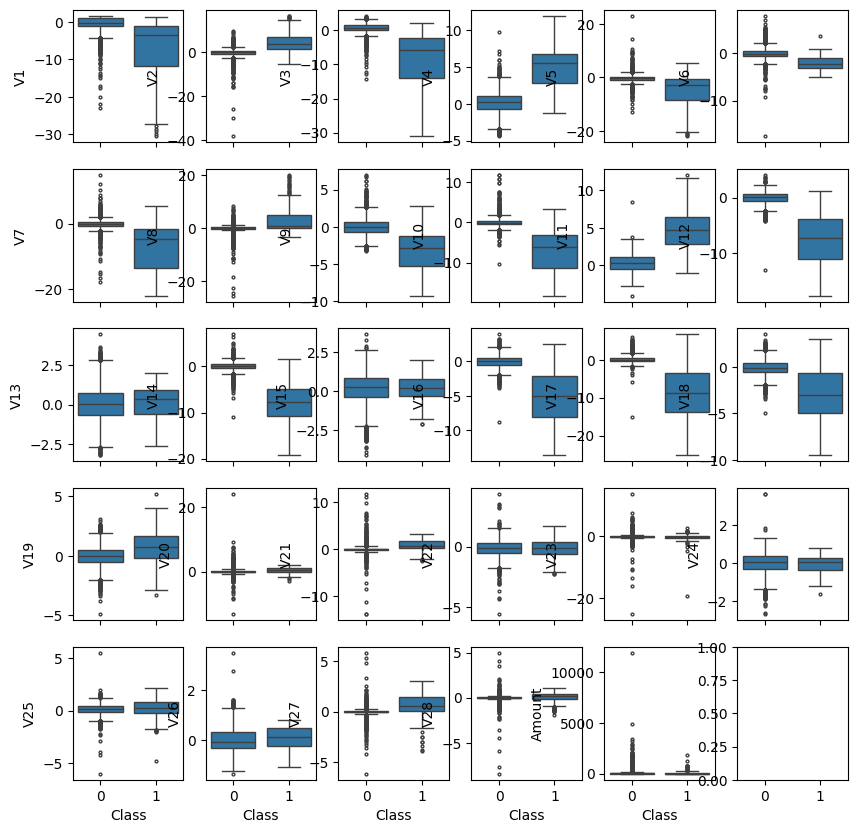

,Columns,P-value
0,V1,5.749575e-303
1,V2,5.624011e-266
2,V3,0.000000e+00
3,V4,0.000000e+00
4,V5,3.917445e-283
5,V6,2.590397e-105
6,V7,0.000000e+00
7,V8,1.224824e-191
8,V9,1.760178e-249
9,V10,0.000000e+00


In [82]:
# Class = int64 전체가 연속형 변수인 경우,
col  = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount' ]

fig, ax = plt.subplots(5,6 , figsize = (10,10), sharex = True)

lst = []
for i, col in enumerate(col) :

  # 각 컬럼을 돌아가면서 Class와 데이터 프레임 만들어주기.
  target = df[[col, 'Class']]

  s, p = ttest_ind(target.query('Class == 0')[col] , target.query("Class ==1")[col])
  lst.append([col, p])
  sns.boxplot(x = 'Class', y = col, data = target, ax = ax.flat[i], flierprops = {'markersize':2})

  t = pd.DataFrame(lst, columns = ['Columns', 'P-value'])

plt.show()

t

변수간 상관관계를 시각화

In [83]:
#fig, ax = plt.subplots(1, figsize = (10,10))
#sns.heatmap(df.corr(method = 'spearman'), annot=True, cmap='coolwarm', fmt=".2f")

In [84]:
## VIF - 상관관계 : 다중 공선성 10 이상일 떄
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

col  = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount' ]

formula = ""
for i in col[:-1] :
  formula += i + "+"

formula += col[-1]  # 마지막 열 추가
f = 'Class ~ ' + formula
y, X = dmatrices(f, df, return_type = 'dataframe')

vif_list = []
for i in range(1, len(X.columns)) :
  vif_list.append([X.columns[i], variance_inflation_factor(X.values, i)])


vif = pd.DataFrame(vif_list , columns = ['variable', 'vif'])
vif[vif['vif'] >= 10]

,variable,vif
1,V2,13.047869
6,V7,13.951544
28,Amount,25.951104


In [85]:
## VIF Solution 2
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

X = df.drop(columns = 'Class', axis=1)
y = df.Class

def check(X, y) :
  X = sm.add_constant(X)
  model = sm.OLS(y,X)
  model.fit()

  # VIF 데이터 프레임 선언
  vif = pd.DataFrame(columns = ['features', 'vif'])

  for i in range( 1, len(model.exog_names)) :
    vif.loc[i, 'features'] = model.exog_names[i]
    vif.loc[i,'vif'] = round(VIF(model.exog, i),3)

  return vif.sort_values('vif', ascending = False)

check(X, y).head(5)



,features,vif
30,Amount,25.991
8,V7,13.98
3,V2,13.048
4,V3,9.108
6,V5,7.54


In [86]:
## 다중 공선성이 높은 변수를 삭제한다.
df1 = df.copy()
df_pre = df1.drop(columns = ['V2', 'V7', 'Amount'], axis = 1)


## 차원 축소 2가지 이상 방법과 장단점

1. PCA
    - 장점 : 데이터의 변동성을 최대화 하는 방향으로, 중요한 특징을 잘 찾아냄 / 선형 변화를 통해 효율적으로 주성분이 중요도를 파악하는데 용이

    - 단점 : 작은 분산을 가지는 성분은 무시 될 가능성이 높고, 비선형 특성을 파악하기 어렵다.

2. t-sne
    - 장점 : 비선형 구조나 군집을 잘 표현할 수 있다. 이웃간 거리를 고려함으로 군집 시각화가 가능하다.
    - 단점 : 변수간 해석이 어렵고, 계산이 오래걸린다.

,PC 0,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,...,PC 20,PC 21,PC 22,PC 23,PC 24,PC 25,PC 26,PC 27,PC 28,PC 29
var,0.260602,0.068175,0.053854,0.046658,0.043043,0.040015,0.037449,0.035601,0.034952,0.034167,...,0.017009,0.016509,0.014459,0.011710,0.011173,0.010154,0.008284,0.006605,0.003784,0.000498
cumsum,0.260602,0.328777,0.382631,0.429289,0.472332,0.512347,0.549795,0.585397,0.620348,0.654516,...,0.916824,0.933333,0.947792,0.959502,0.970675,0.980829,0.989113,0.995719,0.999502,1.000000


<Axes: xlabel='PC1', ylabel='PC2'>

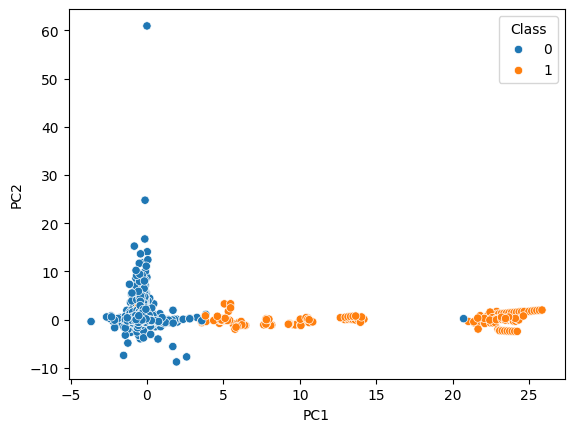

In [87]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
s_x = ss.fit_transform(X)

# PCA
pca = PCA()
X_pca = pca.fit_transform(s_x)

pca = pd.DataFrame(
                  {'var' : pca.explained_variance_ratio_ ,
                  'cumsum' :  pca.explained_variance_ratio_.cumsum()
                  })

pca.index= ['PC ' + str(i) for i in range(len(pca.index))]

display(pca.T)
sns.scatterplot(
pd.DataFrame(X_pca[:, :2] , columns = ['PC1', 'PC2']),
                 x = 'PC1', y = 'PC2', hue = df['Class'])



오버샘플링과 언더샘플링에 대한 설명 및 장단점을 설명하라
**굵은 텍스트**
두 샘플링 기법 모두 데이터 불균형 문제를 해결하기 위한 방법이다.
오버 샘플링은 부족한 클래스의 데이터를 추가로 샘플링 하는 방법이다.
단순 복원샘플링 방식이나 주어진 데이터 사이의 가상 데이터 방식의 샘플링 방식인 SMOTE 방식이 존재한다.

    -장점 : 소수 클래스의 패턴 학습에 도움을 줄 수 있다.
    -단점 : 과적합 문제 발생 할 수 있음
    언더 샘플링은 다수 클래스의 데이터를 줄여서 클래스간 불균형을 해결하는 방식이다.

    -장점 : 클래스 불균형 문제 완화 / 모델 학습 향상
    -단점 : 다수 클래스 정보 손실

In [88]:
display(y.value_counts())

# 불균형이 존재 SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics  import f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


x =X_pca
y= df_pre.Class
## 1) Train, Test 분리 후, Train에 대해서 Over Sampling 진행
x_train, x_test, y_train, y_test = train_test_split(X_pca, y, random_state = 12323, test_size = 0.3)

## 2) SMOTE
smote = SMOTE(random_state = 1234)
x_train_re, y_train_re = smote.fit_resample(x_train, y_train)

## 3) Modelling
rf = RandomForestClassifier()
lr = LogisticRegression()


rf.fit(x_train_re, y_train_re)
lr.fit(x_train_re, y_train_re)

pred_rf = rf.predict(x_test)
pred_lr = lr.predict(x_test)

f1_rf = f1_score(pred_rf, y_test)
f1_lr = f1_score(pred_lr, y_test)

rf_score = rf.score(x_train_re, y_train_re)
lr_score = lr.score(x_train_re, y_train_re)

print(rf_score, lr_score)


Class
0    5723
1     177
Name: count, dtype: int64

1.0 0.9654268597104343


Class 컬럼이 주어지지 않았다고 가정하고 비지도 학습 방식의 이상탐지 모델을 만들려고한다.이상 탐지 모델 2가지 이상 기술하고 장단점을 설명하라

Isolation Forest
- from sklearn.ensemble import IsolationForest </br>

OneClassSVM
- from sklearn.svm import OneClassSVM </br>

DBSCAN
- from sklearn.cluster import DBSCAN / 이상치는 자동으로 -1으로 분류됨 </br>

LocalOutlierFactor
- from sklearn.neighbors import LocalOutlierFactor </br>

AutoEncoder
- 딥러닝 / keras나 pytorch로 구현 , from sklearn.neural_network import
 MLPRegressor 로 가능하지만 파라미터 다양하게 변화시키기에는 한계 있

In [ ]:
from sklearn.ensemble import IsolationForest

isf = IsolationForest(random_state = 2)
isf.fit(x_train_re)

## predict 를 Series로 변환 후, 1 정상, -1 비정상
pred = pd.Series(
                isf.predict(x_test)).map({1:0, -1:1})

print(f1_score(pred, y_test))

2년 전 제품 생산량이 100,000개, 1년 전 제품 생산량이 150,000개, 그 후 팩토리 기술의 상승으로 제품 생산량이 250,000개 되었을 때, 연평균 상승률의 대푯값을 구하시오. (반올림하여 소수점 아래 둘째자리까지 표기하시오.)

In [ ]:
y2 = 100000
y1 = 150000
y0 = 250000

## 성장률 계산 y1 - y2 / y2
y1y2 = (y1 - y2 )/ y2 * 100

## y0 - y1 / y1 (250000 - 150000) / 1500000
y0y1 = ( y0 - y1) / y1 * 100

(y1y2 + y0y1) / 2

# 초기 생산량과 현재 생산량으로 연평균 상승률 계산 (** 거듭제곱)
average_growth_rate = ((250000 / 100000) ** (1/2)) - 1

# 결과 출력
print("연평균 상승률:", round(average_growth_rate, 2))


12건의 광고 시간 측정. 평균 15.5초, 분산 3.2초 일때 90% 신뢰구간은?

In [ ]:
from scipy import stats
import numpy as np

n = 12
x = 15.5
sigma = 3.2
confa = 0.1
df = n-1

t_critical = stats.t.ppf(1- confa/2, df)

# 표준편차
s = np.sqrt(sigma)
# SE
se = s/ np.sqrt(n)

# ME
me = se * t_critical

print(x-me, x+me)

강의 상류와 하류의 생물 다양성 점수에 차이가 있는지 검정하시오. (단, 같은 강에서 상류와 하류는 서로 독립적이지 않으며, 종속적인 관계에 있다.)

-- 문제의 뜻 : 상류와 하류는 서로 영향을 미칠 가능성이 있다. (즉, 독립적이지 않다)

In [ ]:
from scipy.stats import ttest_rel
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/27/river.csv')

## 독립 이다 : 독립 표본 T 검정 -  ttest_ind(data['Up'], data['Down'])
# 서로 다른 두 집단에서 추출된 독립된 표본

# 독립이 아니다: 종속 표본 T 검정
# 동일한 집단에서 두 그룹을 비교하는데 사용 - 같은 강에서 측정된 데이터 임으로, 종속표본으로 간주 ttest_rel(대응표본 사용)

s, p = ttest_rel(df['up'], df['down'])
print(s, p)

분위수 회귀분석 (Quantile Regression) 을 사용하여 회귀 계수를 구하시오. (반올림하여 소수점 아래 둘째자리까지 표기하시오.)

- 분위수 회귀분석
  데이터의 분포에 대한 가정을 하지 않고, y의 여러 분위수에 대한 조건부 분포를 추정하는 회귀 기법. 특정 분위수에 해당하는 y 값을 추정합니다. 예를 들어, 소득과 소비간의 관계를 살펴 볼때 하위소득 그룹과 상위 소득 그룹 사이의 소비 패턴이 서로 다를때, 분위수 회귀분석을 사용하면다양한 소득 수준에서의 소비와 소득간의 관계 파악할 수있다. 데이터의 분포가 비대칭이거나 이상치가 많은 경우에 사용

In [ ]:
import numpy as np
import statsmodels.api  as sm
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/27/problem8.csv')

q =  0.5

X = sm.add_constant(df.drop(columns = 'user_counts', axis = 1))
model = sm.QuantReg(df['user_counts'], X)
res = model.fit(q = q)
res.summary()

8.1의 모델의 회귀계수를 활용하여 temperature : 10.5 , wind : 8.2 , precipitation : 3.5 일때 user_counts를 예측하시오

In [ ]:
## 회귀 계수 상수 추출 .prarams.values
pram = res.params.values
print(pram)

v = np.array([1, 10.5, 8.2, 3.5])
pred = sum(pram * v)

## 모델 클래스에서 바로 적용
res.predict(v)[0]

지하철 호선과 월별, 승객 수 간 상관관계가 있는지 확인(Type III Anova 사용)

- 비균형설계자료의 경우 사용하는 분산분석 방법
- value_counts()로 값들 확인해보고, 비균형설계임을 간단히라도 언급해주자 !
- anova_lm 옵션에 typ=3만 추가해주면 됨

In [ ]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/27/subway.csv')

#display(df['month'].value_counts())
#display(df['line'].value_counts())

# - 상호작용효과에 대한 가설
# HO : 지하철 호선과 월별, 승객수 간 상관관계는 없다.
# H1 : 지하철 호선과 월별, 승객수 간 상관관계가 있다.

# - 주효과 검정에 대한 가설
# H0 : 지하철 호선 승객 수 차이는 존재하지 않는다.
# H1 : 지하철 호선 승객 수 차이는 존재한다.

# H0 : 월별 승객 수 차이는 존재하지 않는다.
# H1 : 월별 승객 수  차이는 존재한다.


# 다중 선형 회귀 모델 정의
model = ols('total ~ line + month + line*month', data=df).fit()

# Type III ANOVA 실행
type3_anova = sm.stats.anova_lm(model, typ=3)
type3_anova